<center><h2>Support Vector Machine Approach for Pulsar Detection in the HTRU2 Dataset</h1></center>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

C:\Users\ArshiaAchar\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### A. Studying the data and identifying target and independent features

In [2]:
  
# fetch dataset 
htru2 = fetch_ucirepo(id=372) 
  
# data (as pandas dataframes) 
X = htru2.data.features           # independent features
y = htru2.data.targets            # dependent features
data = pd.concat([X,y],axis=1)


In [3]:
data.shape

(17898, 9)

There are 17898 rows and 9 columns

In [4]:
print('Independent features: \n',X.columns.tolist())

print('\n Target Variable: \n',y.columns.tolist())

Independent features: 
 ['Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis', 'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis']

 Target Variable: 
 ['class']


The target feature is Class which has values of 0 and 1. The independent variables are:

- profile mean
- profile std dev
- profile skewness
- profile kurtosis
- DM SNR mean
- DM SNR std dev
- DM SNR skewness
- DM SNR kurtosis

The independent variables are statistical measures of radio signals called pulsars, and the target variable is binary, indicating whether a pulsar is present or not.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      17898 non-null  float64
 1   Profile_stdev     17898 non-null  float64
 2   Profile_skewness  17898 non-null  float64
 3   Profile_kurtosis  17898 non-null  float64
 4   DM_mean           17898 non-null  float64
 5   DM_stdev          17898 non-null  float64
 6   DM_skewness       17898 non-null  float64
 7   DM_kurtosis       17898 non-null  float64
 8   class             17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


All features are numerical. With the target being integer

In [6]:
data.describe()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


There is skewness in the data. Mean values are varying largely from the median for all numerical features. The features have large variance as well.

#### B. Check for missing values

In [7]:
data.isnull().sum()

Profile_mean        0
Profile_stdev       0
Profile_skewness    0
Profile_kurtosis    0
DM_mean             0
DM_stdev            0
DM_skewness         0
DM_kurtosis         0
class               0
dtype: int64

There are no missing values.

#### C. Outlier Analysis

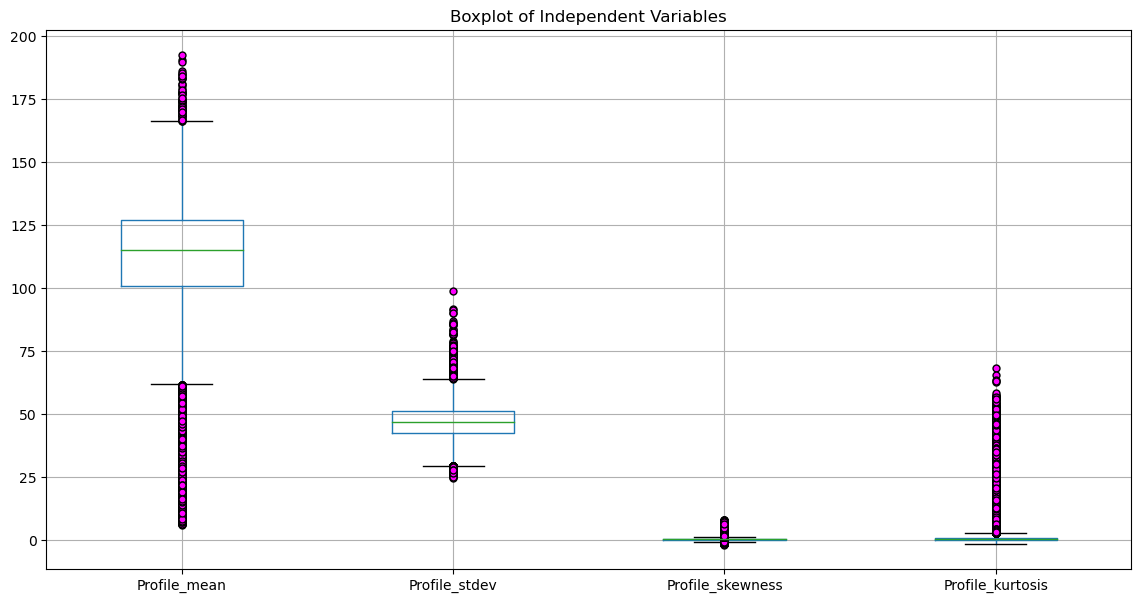

In [8]:
plt.figure(figsize=(14,7))
data.iloc[:, 0:4].boxplot(flierprops=dict(marker='.', markerfacecolor='magenta', markersize=10, linestyle='none'))
plt.title('Boxplot of Independent Variables')
plt.show()

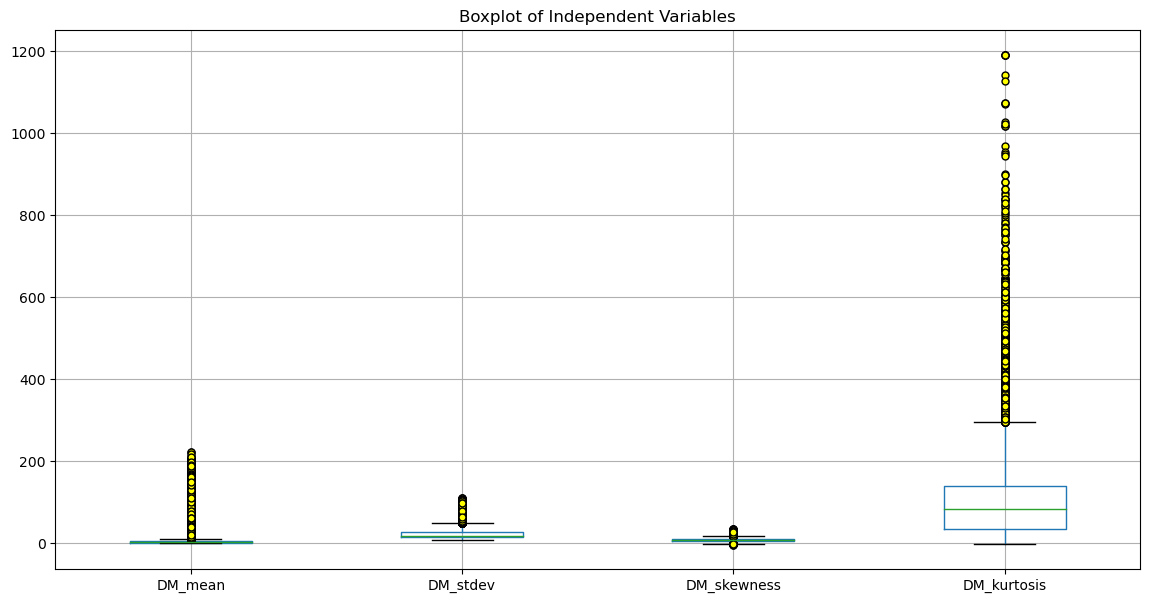

In [9]:
plt.figure(figsize=(14,7))
data.iloc[:, 4:8].boxplot(flierprops=dict(marker='.', markerfacecolor='yellow', markersize=10, linestyle='none'))
plt.title('Boxplot of Independent Variables')
plt.show()

Given the presence of outliers in all features of the dataset, opting for an SVM with a higher value of the C parameter would be best. A higher C value leads to a lower penalty (lambda) for misclassifications, which translates into a SOFTER margin in the SVM model. This softer margin allows the model to be more tolerant to outliers, thereby reducing the influence of these extreme values on the decision boundary. This approach aims to achieve a more robust performance by not overfitting to the outliers.

#### D. Target Feature Distribution

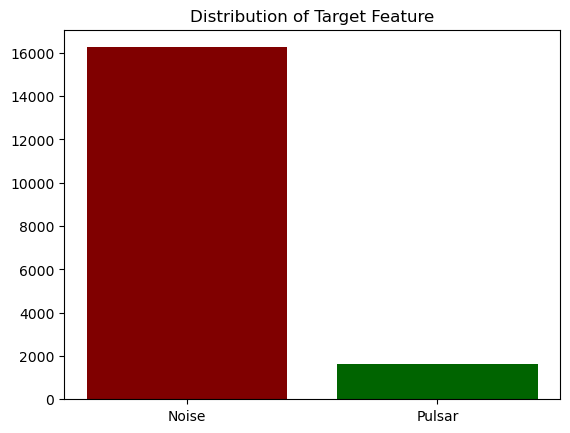

In [10]:
target_counts = data['class'].value_counts()

plt.bar(target_counts.index, target_counts.values,color=['maroon','darkgreen'])
plt.title('Distribution of Target Feature')
plt.xticks([0, 1], ['Noise', 'Pulsar'])
plt.show()

The target feature is binary and the class 0 means that the record is noize and the class 1 would be the sign for a pulsar. In this dataset, most of the records are considered as Noise and are not termed as Pulsars.

It is an imbalanced dataset. Proper techniques need to be followed to balance both classes as target categories should be balanced for Classification problems. Techniques to be considered:

1. undersampling
2. oversampling 
3. SMOTE

Performing SMOTE (Synthetic Minority Oversampling Technique), will artificailly generate more instances of the Pulsar class and this will make models less likely to favor majority class. 

In [11]:
smt = SMOTE(random_state=99)
X_smote, y_smote = smt.fit_resample(X,y)
data1 = pd.concat([X_smote,y_smote],axis=1)

In [12]:
print('Number of records before SMOTE:',data.shape)
print('Number of records after SMOTE:',data1.shape)

Number of records before SMOTE: (17898, 9)
Number of records after SMOTE: (32518, 9)


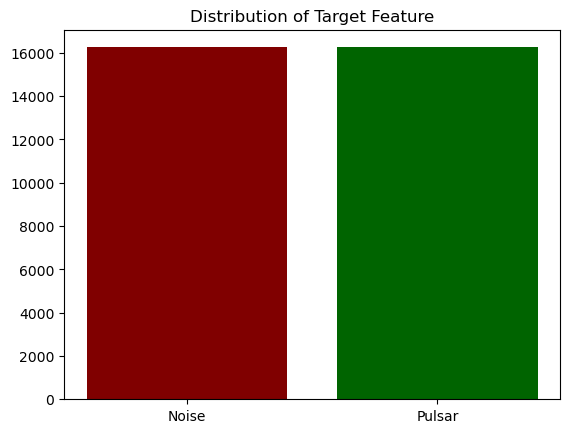

In [13]:
target_counts = data1['class'].value_counts()

plt.bar(target_counts.index, target_counts.values,color=['maroon','darkgreen'])
plt.title('Distribution of Target Feature')
plt.xticks([0, 1], ['Noise', 'Pulsar'])
plt.show()

After SMOTE, both class have been balanced.

#### EFG. Model Building and Model Evaluation

In [14]:
X = data1.iloc[:, 0:8]
y = data1.iloc[:, 8]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for kernel in ['linear', 'rbf', 'sigmoid', 'poly']:
    for C in [1,100,500]:
        model = svm.SVC(kernel=kernel, C=C, gamma='auto')
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
        pred_tr = model.predict(X_train_scaled)

        # Training and Testing Accuracy
        print(f"Kernel: {kernel}, " 
              f"C: {C}, " 
              f"Training Accuracy: {accuracy_score(y_train, pred_tr)}, "
              f"Testing Accuracy: {accuracy_score(y_test, pred)}, " 
              f"Precision: {precision_score(y_test, pred)}, "
              f"Recall: {recall_score(y_test, pred)} ", end='\n---------------------\n')



Kernel: linear, C: 1, Training Accuracy: 0.94376105174137, Testing Accuracy: 0.9412669126691267, Precision: 0.9760026298487837, Recall: 0.9057352043929225 
---------------------
Kernel: linear, C: 100, Training Accuracy: 0.9437226109018221, Testing Accuracy: 0.9415744157441575, Precision: 0.9763313609467456, Recall: 0.9060402684563759 
---------------------
Kernel: linear, C: 500, Training Accuracy: 0.9437226109018221, Testing Accuracy: 0.9415744157441575, Precision: 0.9763313609467456, Recall: 0.9060402684563759 
---------------------
Kernel: rbf, C: 1, Training Accuracy: 0.9481048666102868, Testing Accuracy: 0.9468019680196802, Precision: 0.9793982995421844, Recall: 0.913666870042709 
---------------------
Kernel: rbf, C: 100, Training Accuracy: 0.9531021757515185, Testing Accuracy: 0.9498769987699877, Precision: 0.9792207792207792, Recall: 0.9200732153752288 
---------------------
Kernel: rbf, C: 500, Training Accuracy: 0.955101099408011, Testing Accuracy: 0.9509532595325954, Precis

#### H. Inference on Models:

1. Linear Kernel
As C increases from 1 to 100 and then to 500, the training accuracy, testing accuracy, precision, and recall show very slight improvements. The metrics are nearly the same, indicating that increasing C does not significantly change the model's performance. The linear kernel SVM is less sensitive to changes in C. This suggests that the decision boundary does not change a lot with increasing penalty on misclassification. This could be because the data is linearly separable.

2. RBF Kernel
Incrementing C from 1 to 100, and further to 500 leads to improvements in all metrics: training accuracy, testing accuracy, precision, and recall.
The RBF kernel is more sensitive to changes in C. Higher values of C lead to a stricter margin that attempts to classify more training points correctly, which seems beneficial for this dataset.

3. Sigmoid Kernel
The performance metrics barely change with increase in C. Infact testing accuracy reduced slightly indicating there is overfitting as C parameter increases. The precision, and recall remain consistently low compared to other kernels. The sigmoid kernel's performance does not improve with higher C values, suggesting that it might not be the best choice for this particular dataset, or that it is unable to handle the non-linearities involved as effectively as other kernels.

4. Polynomial Kernel
Increasing C from 1 to 100 and then to 500 results in a noticeable improvement in all performance metrics, with training accuracy, testing accuracy, precision, and recall all increasing. The polynomial kernel benefits from a higher C, indicating a better fit with a stricter margin. This suggests that the polynomial transformations of features at higher penalties help in capturing more complex patterns effectively.

#### I. Any case of overfitting:

Overfitting arises when a model fits too well to the training data but underperforms on the testing data or unseen data. This low generalization of the model is called overfitting.

* The linear kernel has no overfitting and performs consistenly well as all values are nearly the same.

* For the RBF kernel, the training and testing accuracy are both increasing that suggest a good generalization.

* In the sigmoid kernel, there is a slight reduction in testing accuracy with the increase in C parameter and the training accuracy. Even thought this difference is very low it is the only kernel model that shows slight overfitting.

* The polynomial kernel has small increase in training as well as testing accuracy suggesting good generalization.

Best Model: 

- Kernel: rbf 
- C: 500
- Training Accuracy: 0.955101099408011 
- Testing Accuracy: 0.9509532595325954
- Precision: 0.9783381829938571
- Recall: 0.9231238560097621 


## Conclusion

* Models using RBF and polynomial kernels generally exhibited the best performance in terms of accuracy, precision, and recall, improving as the value of C increased. This suggests that these kernels are effective at capturing complex patterns in the dataset.

* Linear Kernel: Shows minimal sensitivity to changes in C. It performs consistently across different C values, indicating stability but it is not very good at capturing complex relationships.

* Sigmoid Kernel: Consistently underperformed across all metrics, suggesting it may not be suitable for this particular dataset. There is no significant evidence of overfitting as the differences between training and testing accuracies are minimal across all kernels as C increases. This is indicative of good generalization capabilities of the models.

* Best Choices: The RBF kernel appears to be the most robust choice, with increasing C values enhancing its ability to classify correctly without significant risks of overfitting.